In [2]:
from briefcase.case import Case
from briefcase.case_base import CaseBase
from briefcase.enums import incons_enum
import import_ipynb
import pandas as pd
import matplotlib.pyplot as plt
import TelcoConverter as TC
import random
import yaml


def get_existing_test_data(cluster="corr", test_split="0.25"):

    filename = f"data/telco-{cluster}-test-{test_split}.yaml"
    
    try:
        with open(filename, 'r') as file:
            data = yaml.safe_load(file)
        print(f"Loaded data successfully from '{filename}'")
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
        print(f"Creating new file")
        data = TC.dataset_to_yaml(cluster, float(test_split))
    except Exception as e:
        print("An error occurred:", str(e))
        
    return data 

def test_constrainted_inconsistency(data, historic_split=0.75, constraint="ALL"):
    # Set the seed for reproducibility
    random.seed(42)
    
    # Randomly select 25% of the data for historic cases
    historic = random.sample(data, k=int(historic_split * len(data)))
    
    print(f"The number of historic cases {len(historic)}")
    
    # The remaining data will be new cases
    new  = [item for item in data if item not in historic]
    
    print(f"The number of new cases {len(new)}")

    
    historic_cases = [Case.from_dict(c) for c in historic]
    cb = CaseBase(historic_cases)  # Todo this is really really slow, but do we care?
    
    not_allowed = 0
    for item in new:
        new_case = Case.from_dict(item)
        if not cb.add_case(new_case, constraint):
            not_allowed += 1
            
    print(f"The number of cases which were not allowed {not_allowed}")    
    size, inconsistencies = cb.metrics()
    return not_allowed, size, inconsistencies

importing Jupyter notebook from TelcoConverter.ipynb


In [7]:
data = []

for historic_split in [0.25, 0.5, 0.75, 0.95]:
    for constraint in ["NO", "NO_NEW", "NO_INVOLVEMENT", "HORTY", "NO_CORRUPTION", "ALL"]:
        print(f"\nHistoric Split: {historic_split}")
        print(f"Constraint: {constraint}")
        not_allowed, cases_size, tainted_cases = (
            test_constrainted_inconsistency(get_existing_test_data(), historic_split=historic_split, constraint=constraint))
        
        data.append({'Historic Split': historic_split, 
                     'Constraint': constraint, 
                     'No. cases not admitted': not_allowed,
                     "No. cases": cases_size,
                     "No. inconsistent cases": tainted_cases})


Historic Split: 0.25
Constraint: NO
Loaded data successfully from 'data/telco-corr-test-0.25.yaml'
The number of historic cases 440
The number of new cases 943
The number of cases which were not allowed 943
Number of cases:  440
Number of tainted cases:  287

Historic Split: 0.25
Constraint: NO_NEW
Loaded data successfully from 'data/telco-corr-test-0.25.yaml'
The number of historic cases 440
The number of new cases 943
The number of cases which were not allowed 183
Number of cases:  1200
Number of tainted cases:  786

Historic Split: 0.25
Constraint: NO_INVOLVEMENT
Loaded data successfully from 'data/telco-corr-test-0.25.yaml'
The number of historic cases 440
The number of new cases 943
The number of cases which were not allowed 364
Number of cases:  1019
Number of tainted cases:  866

Historic Split: 0.25
Constraint: HORTY
Loaded data successfully from 'data/telco-corr-test-0.25.yaml'
The number of historic cases 440
The number of new cases 943
The number of cases which were not all

In [23]:
df = pd.DataFrame(data)
df

,Historic Split,Constraint,No. cases not admitted,No. cases,No. inconsistent cases
0,0.25,NO,943,440,287
1,0.25,NO_NEW,183,1200,786
2,0.25,NO_INVOLVEMENT,364,1019,866
3,0.25,HORTY,103,1280,866
4,0.25,NO_CORRUPTION,0,1383,591
5,0.25,ALL,0,1383,591
6,0.50,NO,529,880,454
7,0.50,NO_NEW,67,1342,668
8,0.50,NO_INVOLVEMENT,285,1124,698
9,0.50,HORTY,37,1372,698


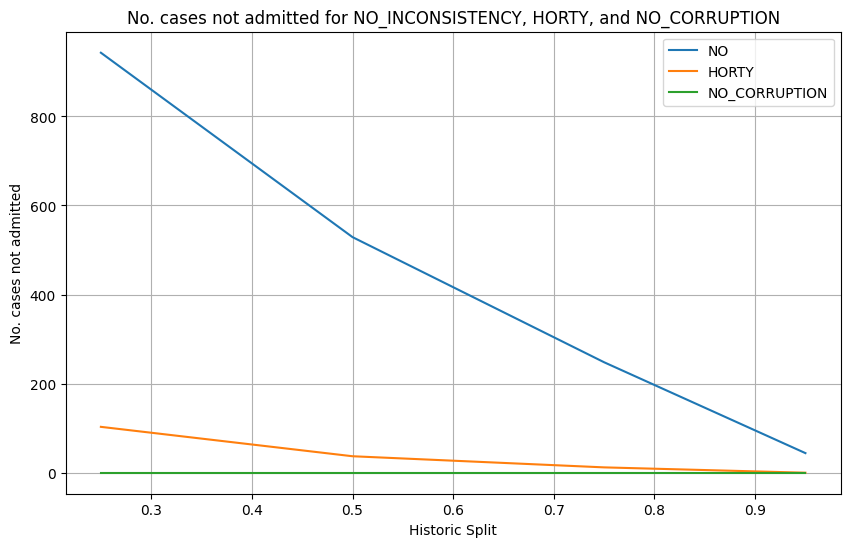

In [25]:
# Filter DataFrame for the constraints HORTY, NO, and NO_CORRUPTION
filtered_df = df[df['Constraint'].isin(['NO', 'HORTY', 'NO_CORRUPTION'])]

# Plotting
plt.figure(figsize=(10, 6))

for constraint in filtered_df['Constraint'].unique():
    sub_df = filtered_df[filtered_df['Constraint'] == constraint]
    plt.plot(sub_df['Historic Split'], sub_df['No. cases not admitted'], label=constraint)

plt.title("No. cases not admitted for NO_INCONSISTENCY, HORTY, and NO_CORRUPTION")
plt.xlabel("Historic Split")
plt.ylabel("No. cases not admitted")
plt.legend()
plt.grid(True)
plt.show()

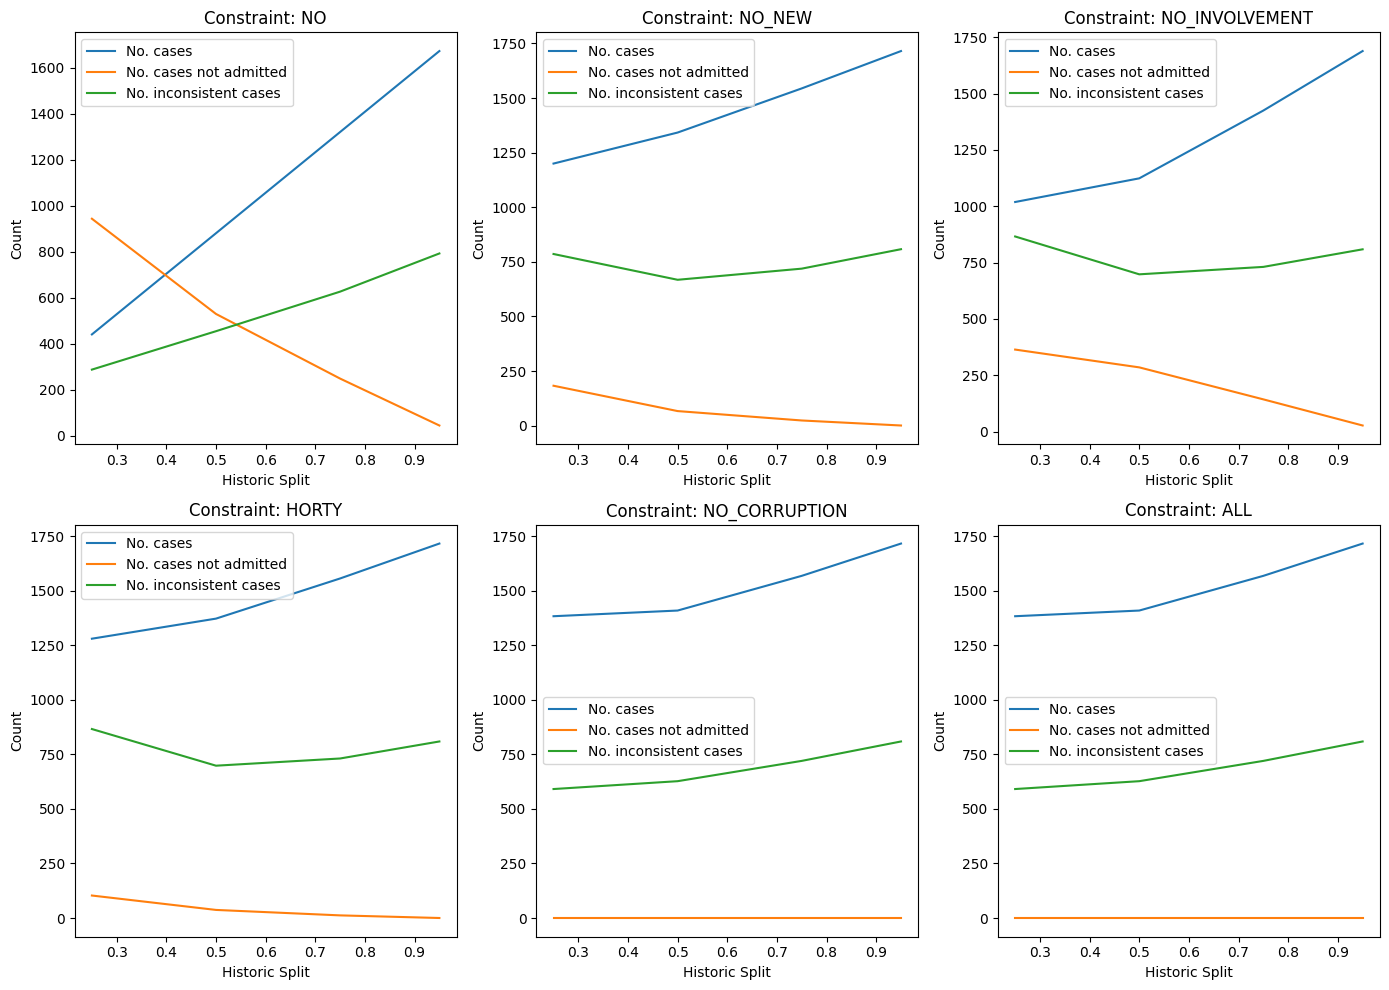

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

for ax, constraint in zip(axes.flatten(), df['Constraint'].unique()):
    sub_df = df[df['Constraint'] == constraint]
    ax.plot(sub_df['Historic Split'], sub_df['No. cases'], label="No. cases")
    ax.plot(sub_df['Historic Split'], sub_df['No. cases not admitted'], label="No. cases not admitted")
    ax.plot(sub_df['Historic Split'], sub_df['No. inconsistent cases'], label="No. inconsistent cases")
    ax.set_title(f"Constraint: {constraint}")
    ax.set_xlabel("Historic Split")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

## Starting from an empty casebase how many admissions before we get an inconsistent set?

In [57]:
import statistics

def test_admit_bf_incons(data, repeats=51):
    # Set the seed for reproducibility
    random.seed(42)
    scores = []
    for k in range(repeats):
        temp_data = data
        random.shuffle(temp_data)
        cb = CaseBase([])  
        score = 0
        for i in range(len(temp_data)):
            new_case = Case.from_dict(temp_data[i])
            if not cb.add_case(new_case, "NO"):
                score = i
                break
            
        scores.append(score)
        print(f"{k}: The number of cases we can admit before we create an inconsistency {score}")

    avg = round(sum(scores) / repeats)
    std_dev = round(statistics.stdev(scores), 2)
    print(f"Average score: {avg}")
    print(f"Standard deviation: {std_dev}")


In [58]:
test_admit_bf_incons(get_existing_test_data())

Loaded data successfully from 'data/telco-corr-test-0.25.yaml'
0: The number of cases we can admit before we create an inconsistency 56
1: The number of cases we can admit before we create an inconsistency 28
2: The number of cases we can admit before we create an inconsistency 70
3: The number of cases we can admit before we create an inconsistency 17
4: The number of cases we can admit before we create an inconsistency 35
5: The number of cases we can admit before we create an inconsistency 15
6: The number of cases we can admit before we create an inconsistency 39
7: The number of cases we can admit before we create an inconsistency 29
8: The number of cases we can admit before we create an inconsistency 44
9: The number of cases we can admit before we create an inconsistency 25
10: The number of cases we can admit before we create an inconsistency 6
11: The number of cases we can admit before we create an inconsistency 37
12: The number of cases we can admit before we create an inc